In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

DATA_PATH = "/kaggle/input/travel-behavior-insights/"

train = pd.read_csv(DATA_PATH + "train.csv")
test  = pd.read_csv(DATA_PATH + "test.csv")

TARGET = "spend_category"
IDCOL = "trip_id"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

print("TRAIN SHAPE:", train.shape)
print("TEST SHAPE :", test.shape)

print("\nMissing Values (%):")
display((train.isna().mean() * 100).sort_values(ascending=False))

TRAIN SHAPE: (12654, 25)
TEST SHAPE : (5852, 24)

Missing Values (%):


has_special_requirements       64.145725
arrival_weather                26.892682
days_booked_before_trip        12.272799
travel_companions               5.824245
total_trip_days                 3.176861
insurance_included              1.865023
country                         1.817607
food_included                   1.351351
intl_transport_included         1.161688
accomodation_included           1.130077
main_activity                   1.011538
is_first_visit                  0.782361
spend_category                  0.268690
age_group                       0.063221
num_males                       0.031611
num_females                     0.015805
info_source                     0.000000
tour_type                       0.000000
island_stay_nights              0.000000
domestic_transport_included     0.000000
sightseeing_included            0.000000
guide_included                  0.000000
mainland_stay_nights            0.000000
visit_purpose                   0.000000
trip_id         

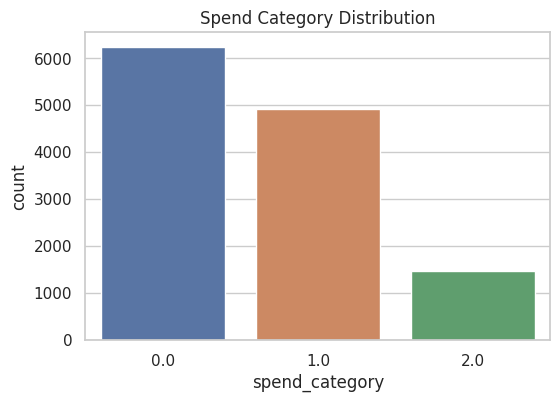

In [3]:
# --- Target distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x=train[TARGET])
plt.title("Spend Category Distribution")
plt.show()

In [4]:
# --- Numeric feature distributions ---
numeric_cols_raw = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_raw = [c for c in numeric_cols_raw if c not in [TARGET]]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


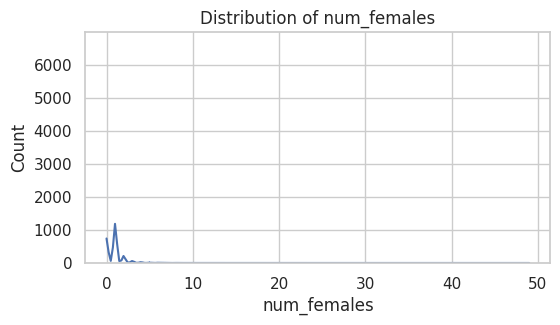

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


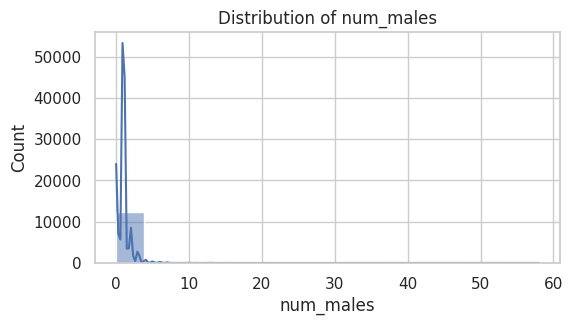

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


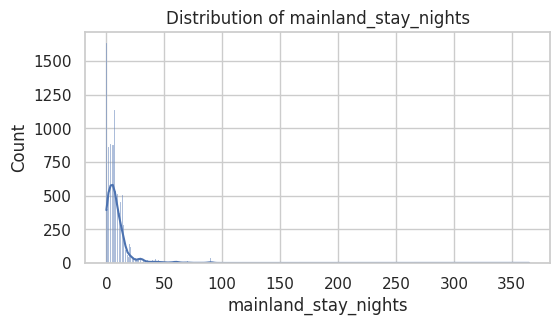

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


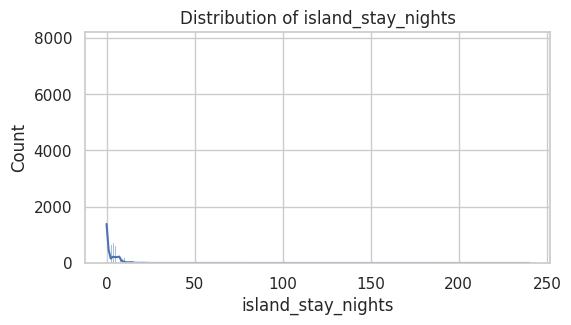

In [5]:
for col in numeric_cols_raw:
    plt.figure(figsize=(6,3))
    sns.histplot(train[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# --- Categorical features (top categories) ---
cat_cols_raw = train.select_dtypes(include="object").columns.tolist()
cat_cols_raw = [c for c in cat_cols_raw if c != IDCOL]

/tmp/ipykernel_13/2040782748.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


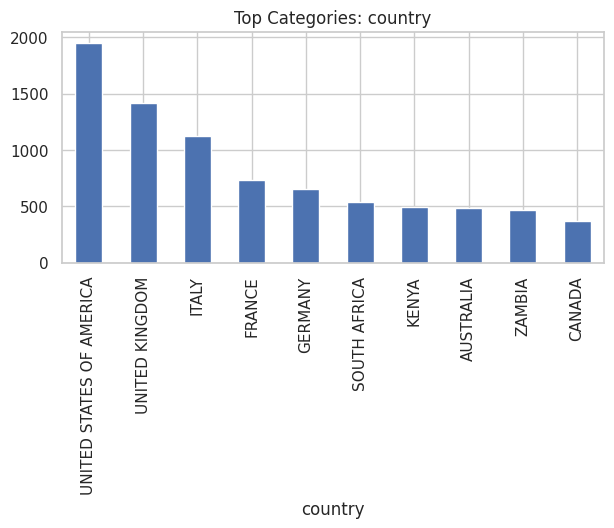

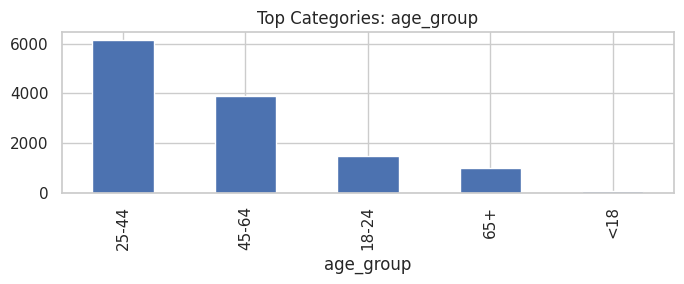

/tmp/ipykernel_13/2040782748.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


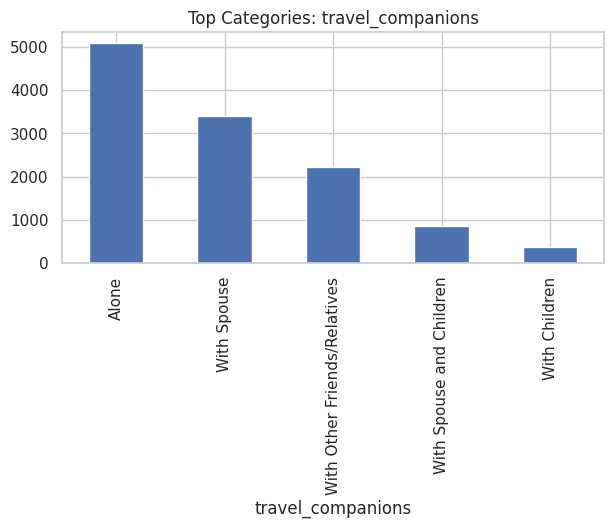

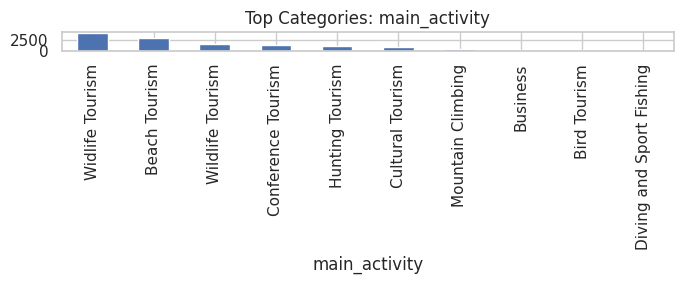

/tmp/ipykernel_13/2040782748.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


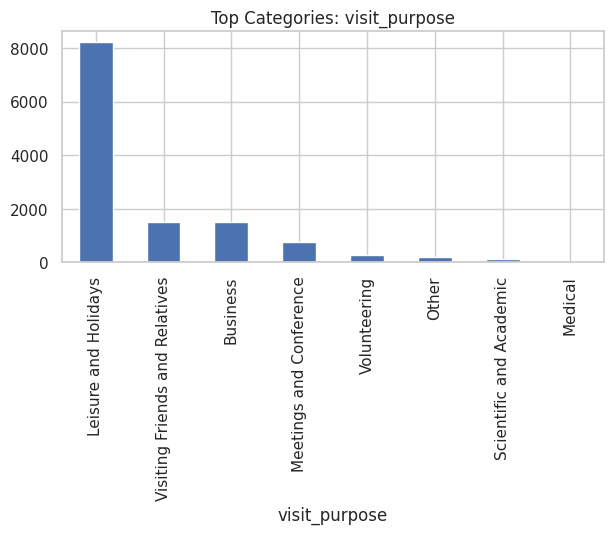

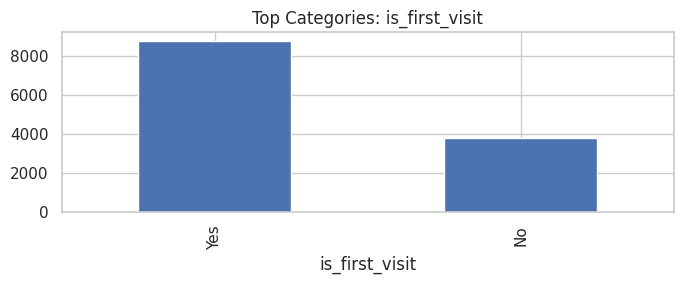

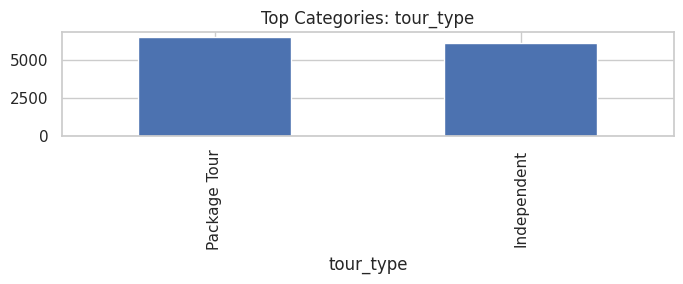

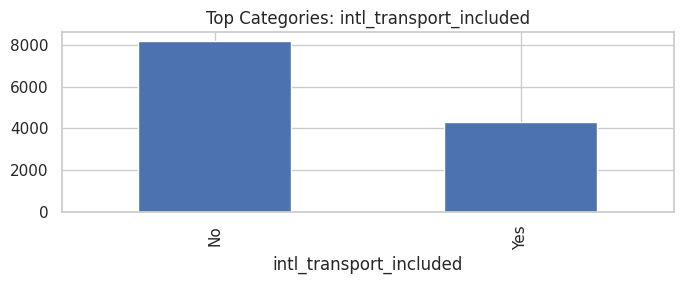

/tmp/ipykernel_13/2040782748.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


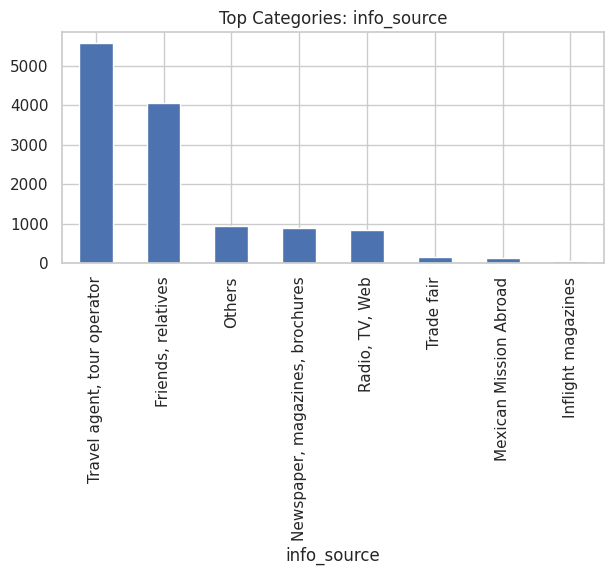

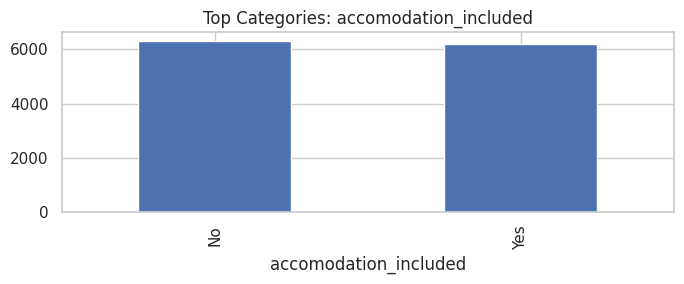

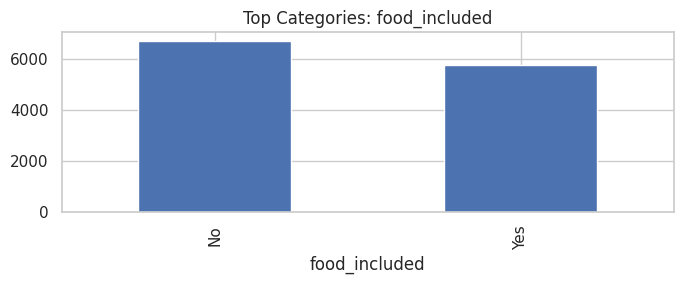

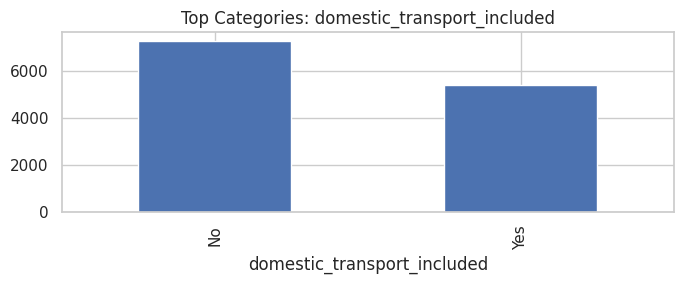

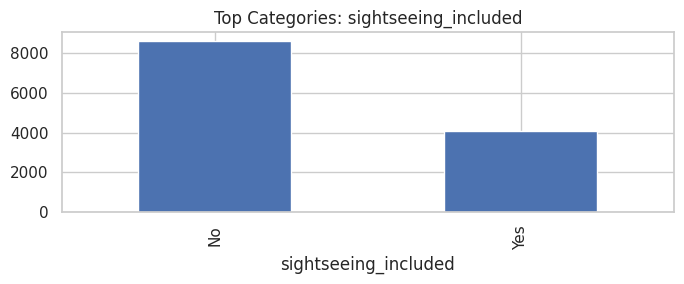

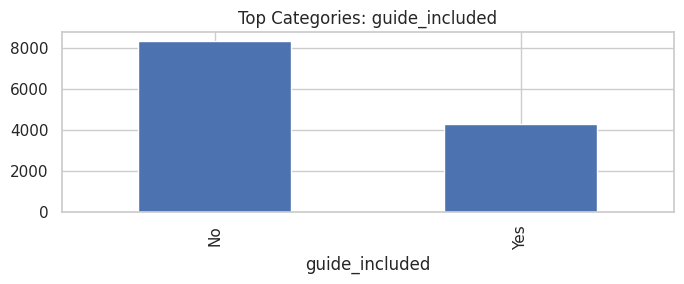

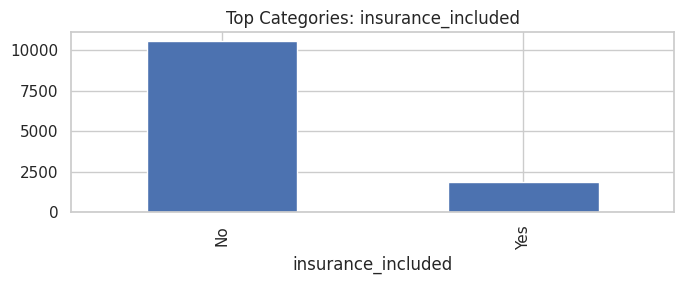

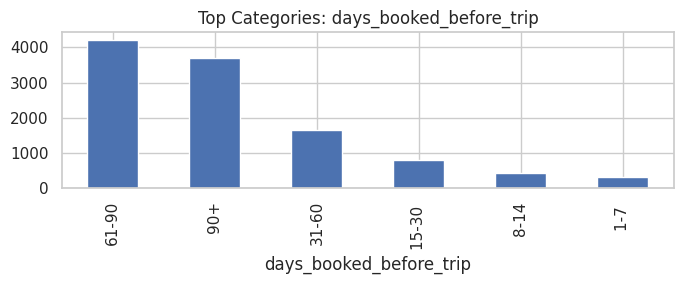

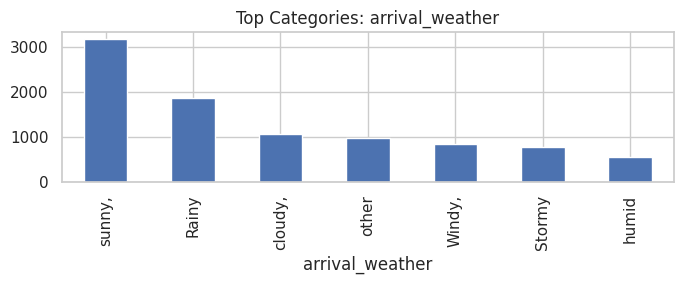

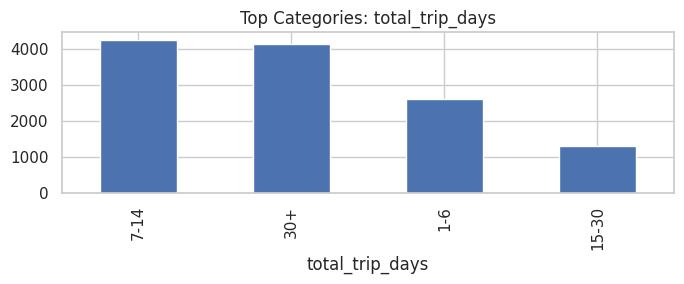

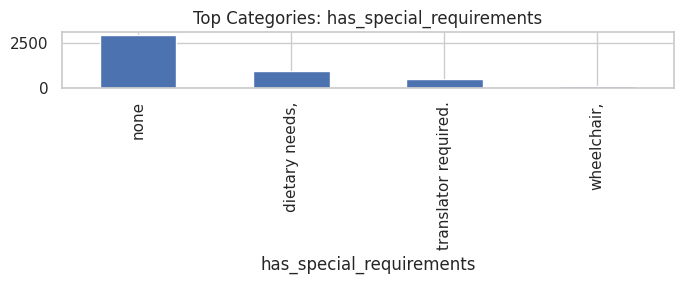

In [6]:
for col in cat_cols_raw:
    plt.figure(figsize=(7,3))
    train[col].value_counts().head(10).plot(kind="bar")
    plt.title(f"Top Categories: {col}")
    plt.tight_layout()
    plt.show()

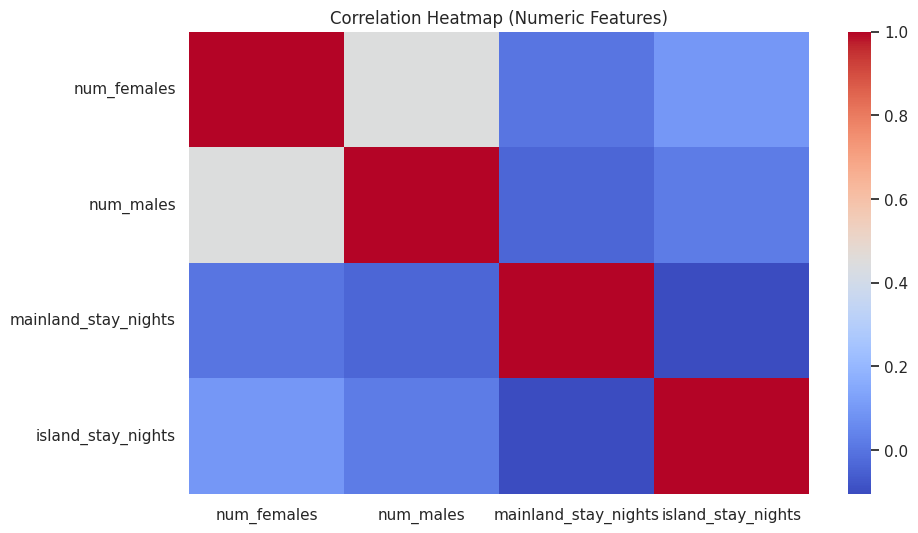

In [7]:
# --- Correlation heatmap for numeric features ---
plt.figure(figsize=(10,6))
sns.heatmap(train[numeric_cols_raw].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [8]:

# Drop rows missing target
train = train[train[TARGET].notna()].reset_index(drop=True)

In [9]:
# 1) Drop high-missing columns (>= 40% missing)
missing_ratio = train.isna().mean()
drop_cols = missing_ratio[missing_ratio >= 0.40].index.tolist()
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=[c for c in drop_cols if c in test.columns], inplace=True)

In [10]:
import warnings

# Suppress specific FutureWarning related to downcasting behavior
warnings.filterwarnings('ignore', message="Downcasting behavior in `replace` is deprecated")

# 2) Detect Yes/No columns automatically
bin_cols = [c for c in train.columns 
            if train[c].astype(str).str.lower().str.strip().isin(["yes","no"]).any()]

def normalize_yes_no(df, col):
    df[col] = df[col].astype(str).str.lower().str.strip()
    df[col] = df[col].replace({"yes": 1, "no": 0, "nan": np.nan})

for df in [train, test]:
    for col in bin_cols:
        normalize_yes_no(df, col)

In [11]:
# 3) Identify ordinal-like ranges via regex (exclude age_group)
pattern = re.compile(r"^\d+-\d+|\d+\+$")
exclude_from_ordinal = ["age_group"]

ordinal_cols = [c for c in train.columns
                if train[c].astype(str).str.contains(pattern).any()
                and c not in exclude_from_ordinal]

def ordinal_map(s):
    cleaned = s.dropna().astype(str).str.strip()
    uniques = cleaned.unique()
    unique_sorted = sorted(uniques, key=lambda x: int(re.sub(r"\D","", x) or 0))
    return {v:i for i,v in enumerate(unique_sorted)}

for col in ordinal_cols:
    mapping = ordinal_map(train[col])
    train[col] = train[col].map(mapping)
    test[col]  = test[col].map(mapping)

# Build X, y
y = train[TARGET].reset_index(drop=True)
X = train.drop(columns=[TARGET, IDCOL])
test_X = test.drop(columns=[IDCOL])

# Split numeric / categorical
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

In [12]:
# 4) Missing value imputation
X[numeric_cols] = SimpleImputer(strategy="median").fit_transform(X[numeric_cols])
test_X[numeric_cols] = SimpleImputer(strategy="median").fit_transform(test_X[numeric_cols])

if categorical_cols:
    X[categorical_cols] = SimpleImputer(strategy="most_frequent").fit_transform(X[categorical_cols])
    test_X[categorical_cols] = SimpleImputer(strategy="most_frequent").fit_transform(test_X[categorical_cols])

In [13]:
# 5) Auto high-card vs low-card
cardinality = {c: X[c].nunique() for c in categorical_cols}
high_card = [c for c,n in cardinality.items() if n > 25]
low_card  = [c for c,n in cardinality.items() if n <= 25]

# Frequency encode high-card
for col in high_card:
    freq = X[col].value_counts(normalize=True)
    X[col+"_freq"] = X[col].map(freq)
    test_X[col+"_freq"] = test_X[col].map(freq).fillna(0)
    X.drop(columns=[col], inplace=True)
    test_X.drop(columns=[col], inplace=True)

# One-hot encode low-card
if low_card:
    ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
    ohe_train = pd.DataFrame(ohe.fit_transform(X[low_card]),
                             columns=ohe.get_feature_names_out(low_card),
                             index=X.index)
    ohe_test = pd.DataFrame(ohe.transform(test_X[low_card]),
                            columns=ohe.get_feature_names_out(low_card),
                            index=test_X.index)
    X = pd.concat([X.drop(columns=low_card), ohe_train], axis=1)
    test_X = pd.concat([test_X.drop(columns=low_card), ohe_test], axis=1)

In [14]:
# 6) Standardize numeric features
numeric_cols_after = X.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X[numeric_cols_after] = scaler.fit_transform(X[numeric_cols_after])
test_X[numeric_cols_after] = scaler.transform(test_X[numeric_cols_after])

In [15]:
# 7) Final processed datasets (trip_id kept ONLY for output)
train_processed = pd.concat([train[IDCOL].reset_index(drop=True), X, y], axis=1)
test_processed = pd.concat([test[IDCOL].reset_index(drop=True), test_X], axis=1)

train_processed.to_csv("/kaggle/working/train_processed.csv", index=False)
test_processed.to_csv("/kaggle/working/test_processed.csv", index=False)

print("Processing complete!")
print(train_processed.shape, test_processed.shape)
train_processed.head()

Processing complete!
(12620, 55) (5852, 54)


,trip_id,num_females,num_males,is_first_visit,mainland_stay_nights,island_stay_nights,intl_transport_included,accomodation_included,food_included,domestic_transport_included,...,"info_source_Radio, TV, Web",info_source_Trade fair,"info_source_Travel agent, tour operator",arrival_weather_Stormy,"arrival_weather_Windy,","arrival_weather_cloudy,",arrival_weather_humid,arrival_weather_other,"arrival_weather_sunny,",spend_category
0,tour_idftaa27vp,0.04408,0.801253,0.654160,-0.632134,0.872270,-0.720683,-0.979761,-0.916471,-0.861470,...,-0.267205,-0.110414,-0.886576,-0.25491,-0.267885,3.316052,-0.213871,-0.289517,-1.041097,1.0
1,tour_iduck75m57,0.04408,-0.817026,0.654160,-0.220032,-0.490401,-0.720683,-0.979761,-0.916471,-0.861470,...,-0.267205,-0.110414,-0.886576,-0.25491,-0.267885,-0.301563,-0.213871,-0.289517,0.960525,2.0
2,tour_id8y3w40h8,0.83203,-0.817026,-1.528679,-0.357399,-0.101067,-0.720683,-0.979761,-0.916471,-0.861470,...,-0.267205,-0.110414,-0.886576,-0.25491,-0.267885,-0.301563,-0.213871,-0.289517,0.960525,2.0
3,tour_idkoh8mkgr,0.04408,-0.007886,0.654160,-0.632134,0.872270,-0.720683,1.020657,1.091142,1.160806,...,-0.267205,-0.110414,1.127934,-0.25491,-0.267885,-0.301563,-0.213871,-0.289517,0.960525,0.0
4,tour_idkmsfa00a,0.04408,-0.007886,0.654160,-0.632134,0.872270,1.387573,1.020657,1.091142,-0.861470,...,-0.267205,-0.110414,1.127934,-0.25491,-0.267885,-0.301563,-0.213871,-0.289517,0.960525,0.0
